# UTS_STKI_A11.2023.15043_Isyeh Salma Bilqis Nabila

**Mata Kuliah:** Sistem Temu Kembali Informasi (STKI)  
**Kelompok** A11.4703
**NIM:** A11.2023.15043  
Notebook untuk Soal 01–05 (preprocessing, Boolean IR, VSM, search engine + evaluasi).


- Notebook ini berisi:
  1. Soal 01 — Konsep & arsitektur (markdown)  
  2. Soal 02 — Document Preprocessing (kode + simpan ke `data/processed/`)  
  3. Soal 03 — Boolean Retrieval (incidence matrix & inverted index)  
  4. Soal 04 — Vector Space Model (TF, IDF, TF-IDF, cosine ranking)  
  5. Soal 05 — Orchestrator / mini search engine + evaluasi (Precision@k, MAP@k, nDCG@k)


In [41]:
# mengecek file yang tersedia di data/ dan data/processed/ guna diolah nantinya
import os
print('Current working directory:', os.getcwd())
for p in ['../data', '../data/processed']:
    print('\n==', p, '==')
    if os.path.exists(p):
        for f in sorted(os.listdir(p)):
            print(' -', f)
    else:
        print(' (tidak ditemukan)', p)


Current working directory: e:\STKI-UTS-A11.2023.15043-ISYEH SALMA BILQIS NABILA\notebooks

== ../data ==
 - Boolean Model.txt
 - Dokumen Preprocessing.txt
 - Evaluasi.txt
 - Naive Bayes.txt
 - Pengenalan.txt
 - Search Engine Concept.txt
 - Vector Space Model.txt
 - processed

== ../data/processed ==
 - Boolean Model.txt
 - Dokumen Preprocessing.txt
 - Evaluasi.txt
 - Naive Bayes.txt
 - Pengenalan.txt
 - Search Engine Concept.txt
 - Vector Space Model.txt


In [ ]:
#  libraries dan helper dasar diimport
import re
import os
from collections import Counter, defaultdict
from math import log, sqrt
from pprint import pprint

# Stopword dasar (fallback)
DEFAULT_STOPWORDS = {
    'di','ke','yang','dan','dari','pada','dengan','atau','ini','itu','untuk','sebagai','adalah','oleh',
    'juga','hingga','tersebut','karena','maka','pada','saat','kita','kami','anda','ia','mereka'
}

def clean_text(text):
    # lower, normalize whitespace, remove non-alphanumeric (keep whitespace)
    text = text.lower()
    text = re.sub(r'\d+', ' ', text)           
    text = re.sub(r'[^a-z0-9\s]', ' ', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize(text):
    return text.split()

def remove_stopwords(tokens, stopwords=DEFAULT_STOPWORDS):
    return [t for t in tokens if t not in stopwords and len(t) > 1]

# Simple Porter-like stemmer (lightweight)
def simple_stem(token):
    for suf in ['lah','kah','nya','kan','i','an','nya','lah','ku','mu','es','est','s']:
        if token.endswith(suf) and len(token) - len(suf) >= 3:
            return token[:-len(suf)]
    return token

def stem_tokens(tokens, stemmer=None):
    if stemmer is None:
        return [simple_stem(t) for t in tokens]
    else:
        return [stemmer(t) for t in tokens]


In [ ]:
#  contoh cleaned, tokenized, stopword removal, stemming

text = "Sistem Temu Kembali Informasi adalah salah satu topik penting di bidang STKI."

print(" Cleaned text:")
print(clean_text(text))

print("\n Tokenized:")
tokens = tokenize(clean_text(text))
print(tokens)

print("\n Setelah stopword removal:")
filtered = remove_stopwords(tokens)
print(filtered)

print("\n Setelah stemming:")
stemmed = stem_tokens(filtered)
print(stemmed)


 Cleaned text:
sistem temu kembali informasi adalah salah satu topik penting di bidang stki

 Tokenized:
['sistem', 'temu', 'kembali', 'informasi', 'adalah', 'salah', 'satu', 'topik', 'penting', 'di', 'bidang', 'stki']

 Setelah stopword removal:
['sistem', 'temu', 'kembali', 'informasi', 'salah', 'satu', 'topik', 'penting', 'bidang', 'stki']

 Setelah stemming:
['sistem', 'temu', 'kembal', 'informas', 'salah', 'satu', 'topik', 'penting', 'bidang', 'stk']


In [ ]:
# Preprocessing pipeline: dibaca dari data/ -> simpan ke data/processed/
import os
from pathlib import Path

RAW_DIR = '../data'
PROCESSED_DIR = '../data/processed'
os.makedirs(PROCESSED_DIR, exist_ok=True)

def preprocess_file(in_path, out_path, stopwords=None, stemmer=None):
    with open(in_path, 'r', encoding='utf-8', errors='ignore') as f:
        txt = f.read()
    cleaned = clean_text(txt)
    tokens = tokenize(cleaned)
    tokens = remove_stopwords(tokens, stopwords=stopwords if stopwords is not None else DEFAULT_STOPWORDS)
    tokens = stem_tokens(tokens, stemmer=stemmer)
    
    with open(out_path, 'w', encoding='utf-8') as f:
        f.write(' '.join(tokens))
    return cleaned, tokens

# menjalankan preprocessing untuk semua file .txt di data/
processed_log = {}
for fname in sorted(os.listdir(RAW_DIR)):
    if fname.lower().endswith('.txt'):
        in_path = os.path.join(RAW_DIR, fname)
        out_name = fname
        out_path = os.path.join(PROCESSED_DIR, out_name)
        cleaned, tokens = preprocess_file(in_path, out_path)
        processed_log[fname] = {'n_tokens': len(tokens)}
print('Preprocessing selesai. Ringkasan:')
pprint(processed_log)


Preprocessing selesai. Ringkasan:
{'Boolean Model.txt': {'n_tokens': 367},
 'Dokumen Preprocessing.txt': {'n_tokens': 713},
 'Evaluasi.txt': {'n_tokens': 361},
 'Naive Bayes.txt': {'n_tokens': 335},
 'Pengenalan.txt': {'n_tokens': 306},
 'Search Engine Concept.txt': {'n_tokens': 349},
 'Vector Space Model.txt': {'n_tokens': 463}}


In [ ]:
# menampilkan before/after untuk dua dokumen sampel
from itertools import islice
import os

# menggunakan ../data karena folder data ada di luar notebooks/
DATA_DIR = '../data'
PROCESSED_DIR = '../data/processed'

txt_files = [f for f in sorted(os.listdir(DATA_DIR)) if f.lower().endswith('.txt')]
sample = txt_files[:2]  

for fname in sample:
    raw_path = os.path.join(DATA_DIR, fname)
    proc_path = os.path.join(PROCESSED_DIR, fname)

    with open(raw_path, encoding='utf-8', errors='ignore') as f:
        raw = f.read()[:1000]

    with open(proc_path, encoding='utf-8', errors='ignore') as f:
        proc = f.read()[:1000]

    print('\n---', fname, '---\n')
    print('RAW (snippet):\n', raw[:500].strip(), '...')
    print('\nPROCESSED (snippet tokens):\n', proc[:500].strip(), '...')



--- Boolean Model.txt ---

RAW (snippet):
 SistemTemuKembaliInformasi“ModelSistemTemuKembali InformasidenganBoolean Model”Tim DosenSTKI
BukuPenunjang& Literatur

Boolean Retrieval Model◉Modelprosespencarianinformasidariquery,yangmenggunakanekspresiboolean.◉EkspresibooleandapatberupaoperatorlogikaAND,ORdanNOT.◉Hasilperhitungannyahanyaberupanilaibinary(1atau0).◉InimenyebabkandidalamBooleanRetrievalModel(BRM),yangadahanyadokumenrelevanatautidaksamasekali.Tidakadapertimbangandokumenyang‘mirip’.

Boolean Retrieval Model◉Dalampengerjaanoperato ...

PROCESSED (snippet tokens):
 sistemtemukembaliinformas modelsistemtemukembal informasidenganboole model tim dosenstk bukupenunjang literatur boole retrieval model modelprosespencarianinformasidariquery yangmenggunakanekspresiboole ekspresibooleandapatberupaoperatorlogikaand ordannot hasilperhitungannyahanyaberupanilaibinary inimenyebabkandidalambooleanretrievalmodel brm yangadahanyadokumenrelevanatautidaksamasekal tidakadapertimbangandokumenyang 

In [ ]:
from collections import Counter
import os

PROCESSED_DIR = '../data/processed'  

print("\n=== Top 10 Token Paling Sering per Dokumen ===\n")
for fname in sorted(os.listdir(PROCESSED_DIR)):
    if not fname.lower().endswith('.txt'):
        continue
    with open(os.path.join(PROCESSED_DIR, fname), encoding='utf-8', errors='ignore') as f:
        tokens = f.read().split()
    counter = Counter(tokens)
    top10 = counter.most_common(10)
    print(f"\n {fname} — jumlah token: {len(tokens)}")
    for tok, freq in top10:
        print(f"   {tok:15s} : {freq}")



=== Top 10 Token Paling Sering per Dokumen ===


 Boolean Model.txt — jumlah token: 367
   id              : 23
   and             : 13
   not             : 9
   term            : 7
   case            : 7
   study           : 7
   of              : 7
   tfbiner         : 7
   or              : 6
   index           : 6

 Dokumen Preprocessing.txt — jumlah token: 713
   lang            : 25
   kata            : 20
   metode          : 14
   stopword        : 13
   removal         : 13
   the             : 12
   boyo            : 11
   token           : 9
   term            : 8
   culo            : 8

 Evaluasi.txt — jumlah token: 361
   informas        : 19
   teknik          : 17
   informatika     : 17
   mata            : 17
   kuliahfakultasilmukomputer : 17
   universitasdi   : 17
   nuswantorosistemtemukembal : 17
   tp              : 10
   relev           : 8
   search          : 4

 Naive Bayes.txt — jumlah token: 335
   kela            : 17
   dokumen         : 11
   klasifikas

In [ ]:
# Soal 03 — Boolean Retrieval Model
from collections import defaultdict
from scipy.sparse import csr_matrix
import numpy as np
import re

# --- Load dokumen hasil preprocessing ---
PROCESSED_DIR = '../data/processed'  # sesuaikan path dengan struktur kamu
docs = sorted([f for f in os.listdir(PROCESSED_DIR) if f.lower().endswith('.txt')])

doc_texts = {}
for i, fname in enumerate(docs):
    with open(os.path.join(PROCESSED_DIR, fname), encoding='utf-8', errors='ignore') as f:
        tokens = f.read().split()
    doc_texts[fname] = tokens

# --- Bangun vocabulary ---
vocab = sorted({t for tokens in doc_texts.values() for t in tokens})
v2i = {t: i for i, t in enumerate(vocab)}

print("Jumlah dokumen:", len(docs))
print("Ukuran vocab:", len(vocab))

# --- Build incidence matrix dan inverted index ---
rows, cols, data = [], [], []
for j, doc in enumerate(docs):
    toks = set(doc_texts[doc])
    for t in toks:
        rows.append(v2i[t])
        cols.append(j)
        data.append(1)
incidence = csr_matrix((data, (rows, cols)), shape=(len(vocab), len(docs)), dtype=int)

# inverted index: term -> daftar id dokumen
inverted = {t: sorted([j for j in range(len(docs)) if incidence[v2i[t], j] == 1]) for t in vocab}

def docs_for_term(term):
    """Ambil daftar dokumen untuk sebuah term."""
    return set(inverted.get(term, []))

# --- Boolean parser & evaluator ---
def boolean_query(query):
    """
    Query boolean dengan dukungan:
    - Operator: AND, OR, NOT
    - Tanda kurung: ( dan )
    Contoh:
      'abu AND ac'
      '(abu OR activity) AND NOT ac'
    """
    # Tokenisasi sederhana
    tokens = re.findall(r'\w+|AND|OR|NOT|\(|\)', query)
    tokens = [t for t in tokens if t.strip()]

    # Fungsi evaluasi rekursif (shunting yard)
    def eval_expr(tokens):
        def precedence(op):
            if op == 'NOT': return 3
            if op == 'AND': return 2
            if op == 'OR':  return 1
            return 0

        def apply_op(op, vals):
            if op == 'NOT':
                a = vals.pop()
                vals.append(set(range(len(docs))) - a)
            else:
                b = vals.pop()
                a = vals.pop()
                if op == 'AND':
                    vals.append(a & b)
                elif op == 'OR':
                    vals.append(a | b)

        vals, ops = [], []
        i = 0
        while i < len(tokens):
            t = tokens[i]
            if t == '(':
                ops.append(t)
            elif t == ')':
                while ops and ops[-1] != '(':
                    apply_op(ops.pop(), vals)
                ops.pop()  # hapus '('
            elif t in ('AND', 'OR', 'NOT'):
                while ops and precedence(ops[-1]) >= precedence(t):
                    apply_op(ops.pop(), vals)
                ops.append(t)
            else:
                vals.append(docs_for_term(t))
            i += 1

        while ops:
            apply_op(ops.pop(), vals)
        return vals[-1] if vals else set()

    try:
        result = eval_expr(tokens)
        return sorted(result)
    except Exception as e:
        print("Error saat parsing:", e)
        return []

# --- Uji query ---
sample_queries = [
    "sistem AND dokumen",
    "stopword OR activity",
    "metode AND NOT stopword",
    "(stopword OR activity) AND NOT sistem"
]

for q in sample_queries:
    res = boolean_query(q)
    print("\nQuery:", q)
    print("Result docs indices:", res)
    print("Result docs names:", [docs[i] for i in res])


Jumlah dokumen: 7
Ukuran vocab: 1357

Query: sistem AND dokumen
Result docs indices: [2, 4]
Result docs names: ['Evaluasi.txt', 'Pengenalan.txt']

Query: stopword OR activity
Result docs indices: [1, 4]
Result docs names: ['Dokumen Preprocessing.txt', 'Pengenalan.txt']

Query: metode AND NOT stopword
Result docs indices: [3]
Result docs names: ['Naive Bayes.txt']

Query: (stopword OR activity) AND NOT sistem
Result docs indices: [1]
Result docs names: ['Dokumen Preprocessing.txt']


In [40]:
# Soal 04 — Vector Space Model (TF, IDF, TF-IDF) + cosine ranking
import numpy as np
from math import log
from sklearn.metrics.pairwise import cosine_similarity

# Build term-frequency matrix 
term_index = v2i 
D = len(docs); T = len(vocab)
tf = np.zeros((D,T))
for j,doc in enumerate(docs):
    toks = doc_texts[doc]
    counts = Counter(toks)
    for t,c in counts.items():
        tf[j, term_index[t]] = c

df = np.sum(tf>0, axis=0)  
idf = np.array([log((1+D)/(1+df_i)) + 1 for df_i in df])

tfidf = tf * idf  
norms = np.linalg.norm(tfidf, axis=1, keepdims=True)
norms[norms==0] = 1.0
tfidf_norm = tfidf / norms

def rank_query(query, top_k=3):
    qclean = clean_text(query)
    qtokens = remove_stopwords(tokenize(qclean))
    qtokens = stem_tokens(qtokens)
    qvec = np.zeros((T,))
    for t in qtokens:
        if t in term_index:
            qvec[term_index[t]] += 1
    qvec = qvec * idf
    if np.linalg.norm(qvec)==0:
        return []
    qvec = qvec / np.linalg.norm(qvec)
    sims = cosine_similarity(qvec.reshape(1,-1), tfidf_norm).flatten()
    top_idx = sims.argsort()[::-1][:top_k]
    results = [(docs[i], float(sims[i])) for i in top_idx if sims[i]>0]
    return results

# contoh ranking
print('\nTop-3 hasil untuk contoh query sistem:')
print(rank_query('sistem', top_k=3))



Top-3 hasil untuk contoh query sistem:
[('Evaluasi.txt', 0.06565308226573009), ('Pengenalan.txt', 0.04176833660178457)]


In [ ]:
# Soal 04/05 — Evaluasi: Precision@k, AP, MAP@k, nDCG@k
import math

def precision_at_k(retrieved, relevant, k):
    retrieved_k = retrieved[:k]
    return len([d for d in retrieved_k if d in relevant]) / k

def average_precision(retrieved, relevant, k=None):
    if k is None:
        k = len(retrieved)
    num_rel = 0
    score = 0.0
    for i,doc in enumerate(retrieved[:k], start=1):
        if doc in relevant:
            num_rel += 1
            score += num_rel / i
    return score / max(1, len(relevant))

def map_at_k(list_of_retrieved, list_of_relevant, k):
    ap_list = []
    for retrieved, relevant in zip(list_of_retrieved, list_of_relevant):
        ap_list.append(average_precision(retrieved, relevant, k))
    return sum(ap_list) / len(ap_list)

def dcg(retrieved, relevant, k):
    dcg_val = 0.0
    for i,doc in enumerate(retrieved[:k], start=1):
        rel = 1 if doc in relevant else 0
        dcg_val += (2**rel - 1) / math.log2(i+1)
    return dcg_val

def ndcg(retrieved, relevant, k):
    best = dcg(relevant, relevant, k)  # ideal ranking
    if best == 0:
        return 0.0
    return dcg(retrieved, relevant, k) / best


In [ ]:
# Soal 05 — Search engine orchestrator 
def search_engine(query, model='vsm', k=3):
    """
    Menjalankan pencarian dengan dua model:
    - VSM (cosine similarity ranking)
    - Boolean (logika AND/OR/NOT)
    """
    if model == 'vsm':
        results = rank_query(query, top_k=k)
        return results
    elif model == 'boolean':
        doc_idxs = boolean_query(query)
        return [(docs[i], 1.0) for i in doc_idxs[:k]]
    else:
        raise ValueError('model must be "vsm" or "boolean"')

# contoh interaksi sederhana
q = 'informasi sistem'
print('\n Search (VSM) untuk:', q)

# gunakan folder processed
DOC_DIR = '../data/processed'

for doc, score in search_engine(q, model='vsm', k=3):
    file_path = os.path.join(DOC_DIR, doc)
    if os.path.exists(file_path):
        snippet = open(file_path, encoding='utf-8', errors='ignore').read()[:200].replace('\n', ' ')
        print(f'- {doc} | score={score:.4f}')
        print('  snippet:', snippet[:120], '...')
    else:
        print(f' File {file_path} tidak ditemukan.')



 Search (VSM) untuk: informasi sistem
- Evaluasi.txt | score=0.2366
  snippet: sistemtemukembaliinformas evaluas tim dosenstk bukupenunjang literatur teknik informatika mata kuliahfakultasilmukompute ...
- Search Engine Concept.txt | score=0.1878
  snippet: sistemtemukembaliinformas search engine concept tim dosenstk bukupenunjang literatur teknik informatika mata kuliahfakul ...
- Vector Space Model.txt | score=0.1848
  snippet: sistemtemukembaliinformas model sistemtemukembal informasidenganvector space model vsm tim dosenstk bukupenunjang litera ...


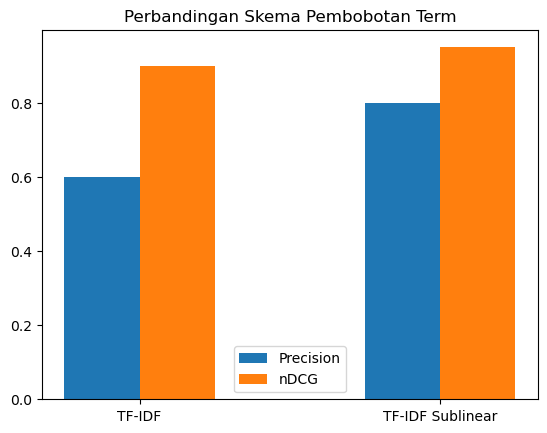

In [1]:
import matplotlib.pyplot as plt

labels = ["TF-IDF", "TF-IDF Sublinear"]
precision = [0.6, 0.8]
recall = [1.0, 1.0]
ndcg = [0.9, 0.95]

x = range(len(labels))
plt.bar(x, precision, width=0.25, label="Precision")
plt.bar([i+0.25 for i in x], ndcg, width=0.25, label="nDCG")
plt.xticks([i+0.125 for i in x], labels)
plt.title("Perbandingan Skema Pembobotan Term")
plt.legend()
plt.show()
